In [1]:
%%capture
!pip install creversi

In [2]:
from creversi import *

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from copy import copy

import torch
import torch.nn as nn

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# # 旧モデル
# class PolicyNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         n_filters = 80
#         self.input_layer = nn.Sequential(
#             nn.Conv2d(8,n_filters,kernel_size=5,padding=2),
#             nn.ReLU()
#         )
#         self.hidden_layer = nn.Sequential(
#             nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
#             nn.ReLU(),
#             nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
#             nn.ReLU(),
#             nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
#             nn.ReLU(),
#             nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
#             nn.ReLU(),
#             nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
#             nn.ReLU(),
#             nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
#             nn.ReLU(),
#             nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
#             nn.ReLU(),
#             nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
#             nn.ReLU(),
#             nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
#             nn.ReLU(),
#             nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
#             nn.ReLU(),
#             nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
#             nn.ReLU()
#         )
#         self.output_layer = nn.Sequential(
#             nn.Conv2d(n_filters,1,kernel_size=1),
#             nn.Flatten()
#         )
        
#     def forward(self,x):
#         out = self.input_layer(x)
#         out = self.hidden_layer(out)
#         out = self.output_layer(out)
#         return out

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        n_filters = 100
        self.input_layer = nn.Sequential(
            nn.Conv2d(8,n_filters,kernel_size=5,padding=2),
            nn.ReLU()
        )
        self.hidden_layer = nn.Sequential(
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU()
        )
        self.output_layer = nn.Sequential(
            nn.Conv2d(n_filters,1,kernel_size=1),
            nn.Flatten()
        )
        
    def forward(self,x):
        out = self.input_layer(x)
        out = self.hidden_layer(out)
        out = self.output_layer(out)
        return out

In [5]:
def board_to_array(board):
    """
    boardオブジェクトからndarrayに変換する関数(PolicyNetwork用)。
    第1チャンネルは黒石の位置、第2チャンネルに白石の位置、第3チャンネルに空白の位置、
    第4チャンネルに合法手の位置、第5チャンネルに返せる石の個数、第6チャンネルに隅=1、
    第7チャンネルに1埋め、第8チャンネルに0埋め。
    """
    b = np.zeros((8,8,8), dtype=np.float32)
    board.piece_planes(b)
    if not board.turn:
        b = b[[1,0,2,3,4,5,6,7],:,:]
    b[2] = np.where(b[0]+b[1]==1, 0, 1)
    legal_moves = list(board.legal_moves)
    if legal_moves != [64]:
        n_returns = []
        for move in legal_moves:
            board_ = copy(board)
            n_before = board_.opponent_piece_num()
            board_.move(move)
            n_after = board_.piece_num()
            n_returns.append(n_before-n_after)
        tmp = np.zeros(64)
        tmp[legal_moves] = n_returns
        tmp = tmp.reshape(8,8)
        b[3] = np.where(tmp > 0,1,0)
        b[4] = tmp
    b[5] = np.array([1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.]).reshape(8,8)
    b[6] = 1
    return b

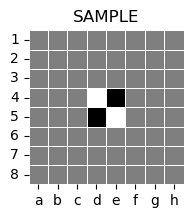

In [6]:
def show_board(board,title='',prob=None):
    """boardの状態とPolicyNetworkの出力を表示する関数"""
    board_arr = board_to_array(board)
    B = board_arr[2]*0.5
    B += board_arr[0]
    plt.figure(figsize=(2,2))
    sns.heatmap(B, cmap='gray_r',cbar=False,linewidths=0.5)
    if prob is not None:
        sns.heatmap(prob, cmap='gray_r',annot=True, fmt='.0f',alpha=0,cbar=False)
    plt.xticks(ticks=np.arange(0.5,8.5),labels=list('abcdefgh'))
    plt.yticks(ticks=np.arange(0.5,8.5),labels=list('12345678'),rotation=0)
    plt.title(title)
    plt.show()
    
board = Board()
show_board(board,'SAMPLE')

In [7]:
def receive_input(legal_moves):
    """ユーザからの入力を受け取る関数"""
    legal_moves_str = [move_to_str(move) for move in legal_moves]
    move_str = input('Your turn : ')
    if move_str == '0':
        return '0'
    while move_str not in legal_moves_str:
        move_str = input('Invalid input. Try again : ')
    move = move_from_str(move_str)
    return move

In [8]:
# 学習済みモデルの読み込み
# model = torch.load('/kaggle/input/reversi-datasets/results/SL-PolicyNetwork-v2-checkpoint-1epoch-subdata299.pth')
# model = torch.load('/kaggle/input/reversi-datasets/results_RL/RL-PolicyNetwork-checkpoint-3.pth')
model = torch.load('/kaggle/input/reversi-datasets/SL-PolicyNetwork-v3-checkpoint-5epoch-subdata99.pth')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

黒番：You

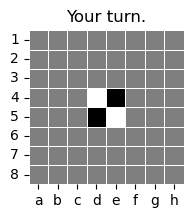

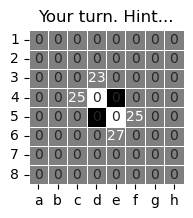

Your turn :  e6


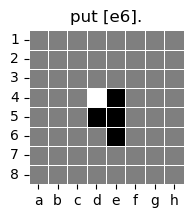

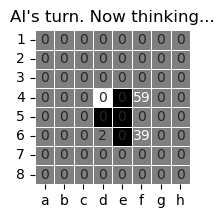

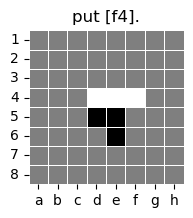

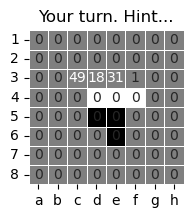

Your turn :  d3


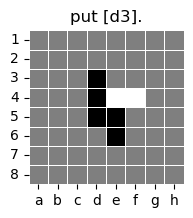

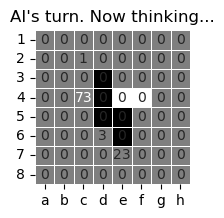

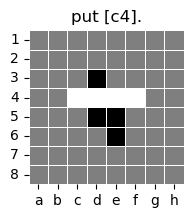

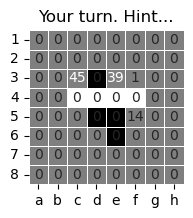

Your turn :  c3


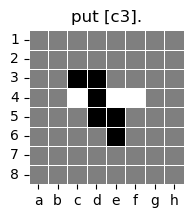

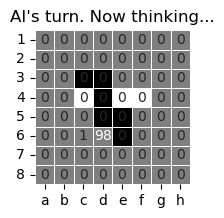

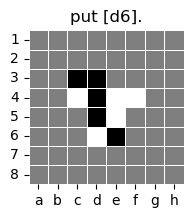

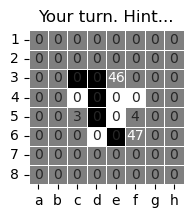

Your turn :  e3


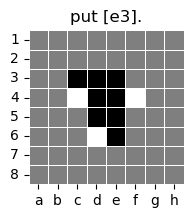

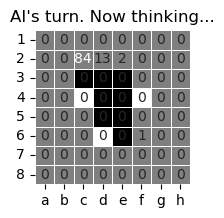

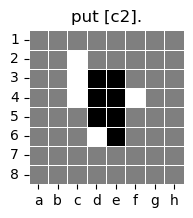

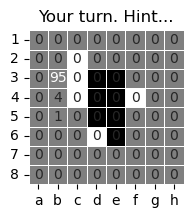

Your turn :  b3


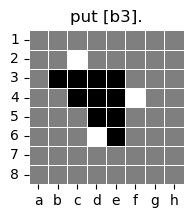

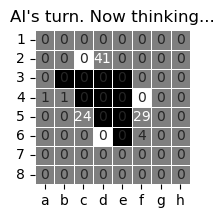

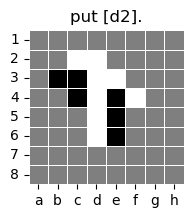

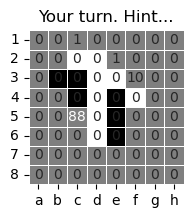

Your turn :  f3


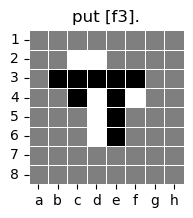

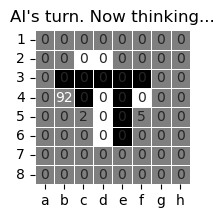

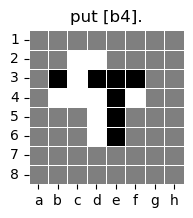

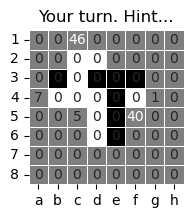

Your turn :  f5


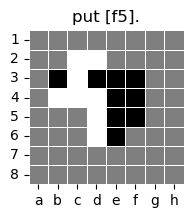

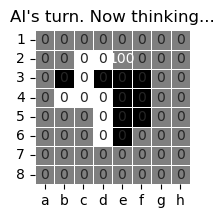

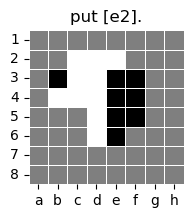

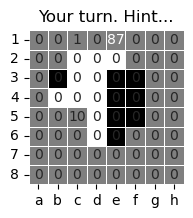

Your turn :  e1


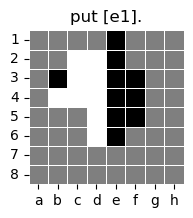

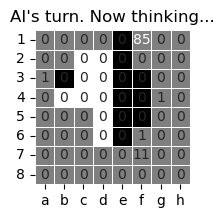

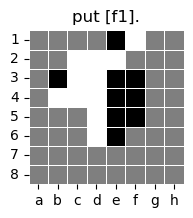

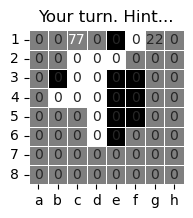

Your turn :  g1


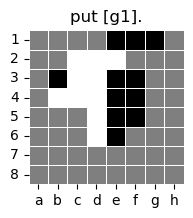

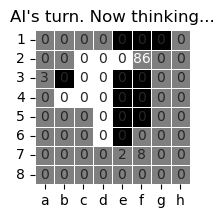

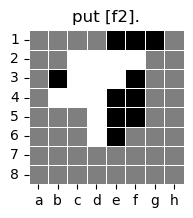

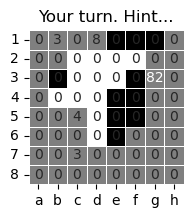

Your turn :  g3


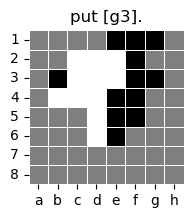

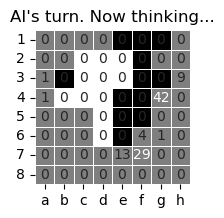

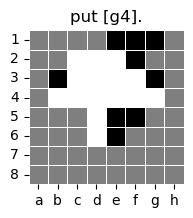

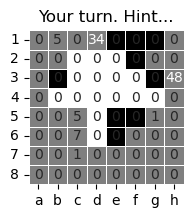

Your turn :  c5


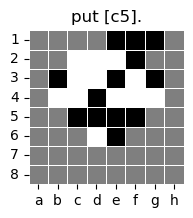

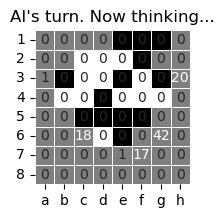

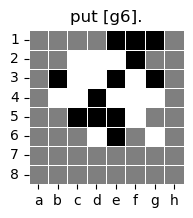

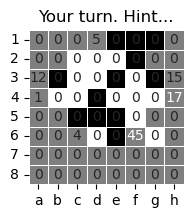

Your turn :  h3


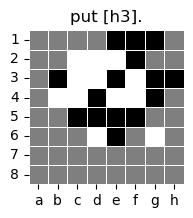

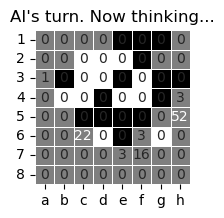

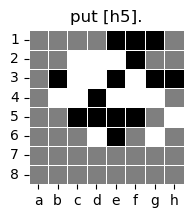

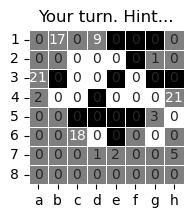

Your turn :  a3


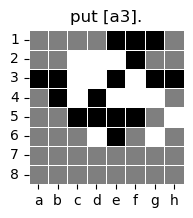

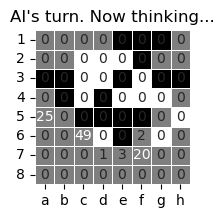

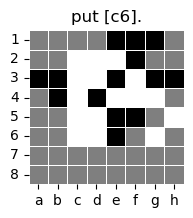

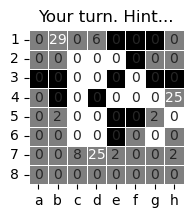

Your turn :  h4


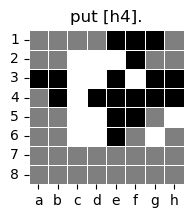

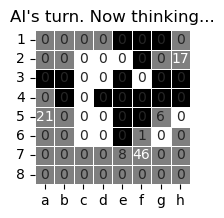

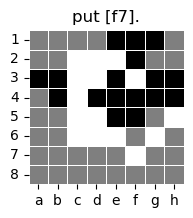

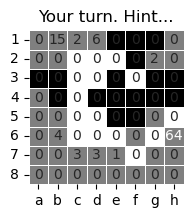

Your turn :  h6


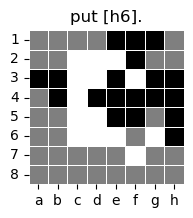

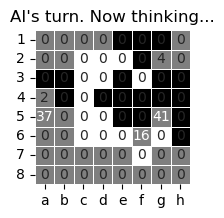

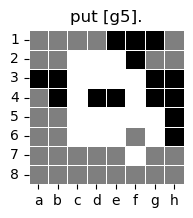

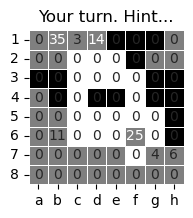

Your turn :  b1


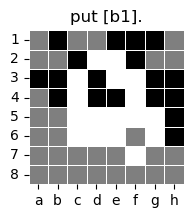

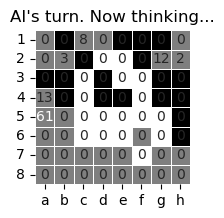

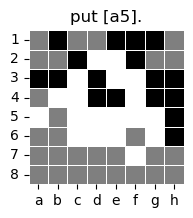

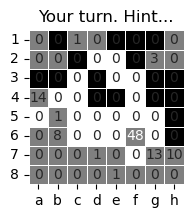

Your turn :  g7


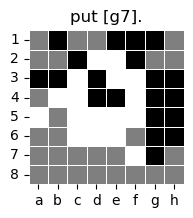

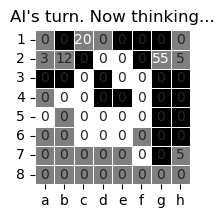

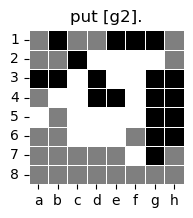

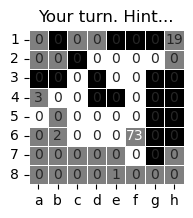

Your turn :  e8


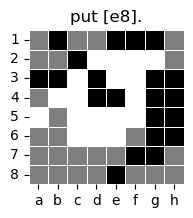

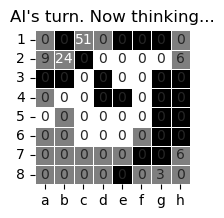

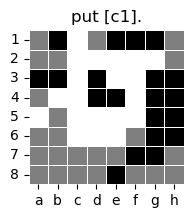

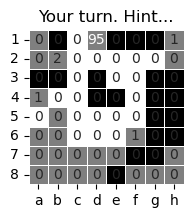

Your turn :  d1


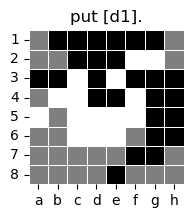

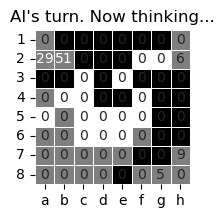

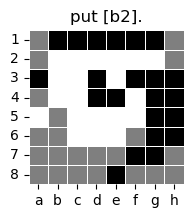

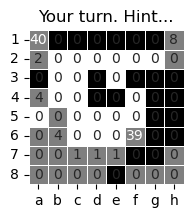

Your turn :  a1


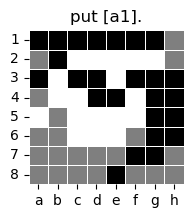

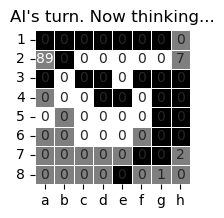

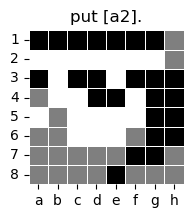

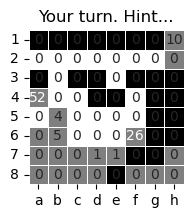

Your turn :  a4


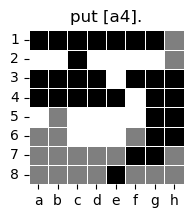

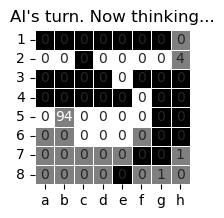

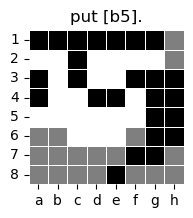

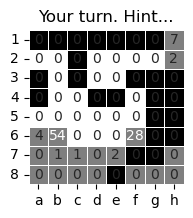

Your turn :  a6


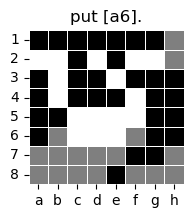

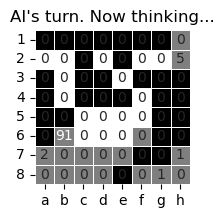

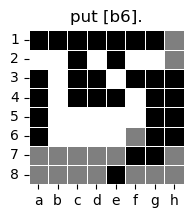

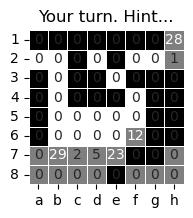

Your turn :  b7


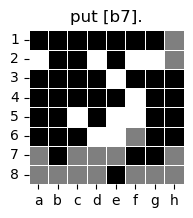

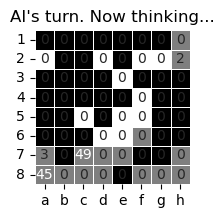

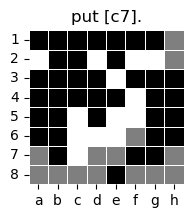

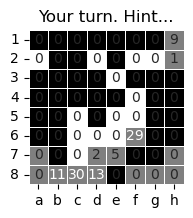

Your turn :  c8


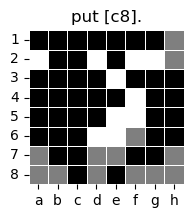

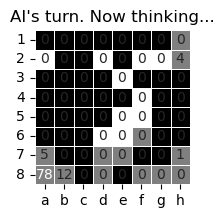

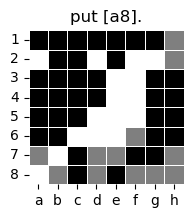

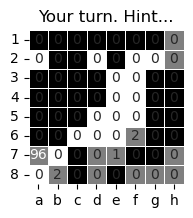

Your turn :  a7


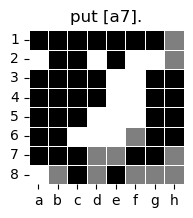

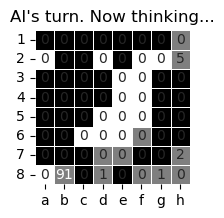

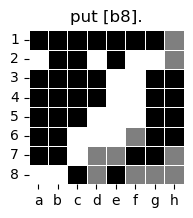

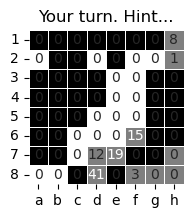

Your turn :  d8


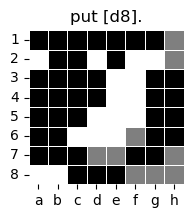

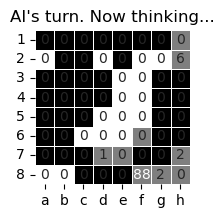

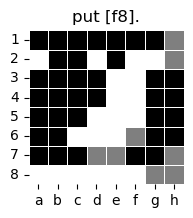

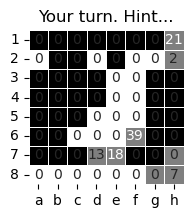

Your turn :  e7


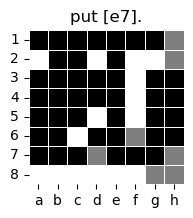

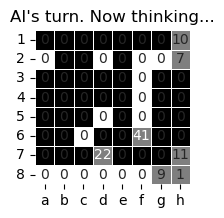

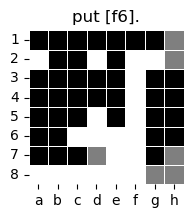

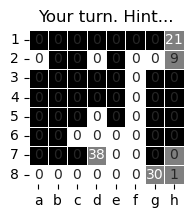

Your turn :  d7


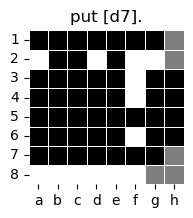

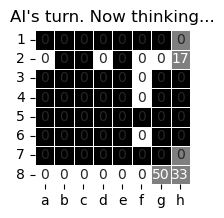

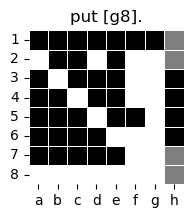

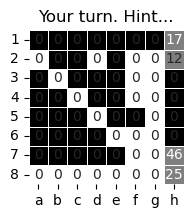

Your turn :  h1


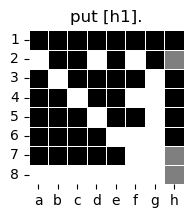

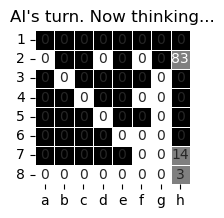

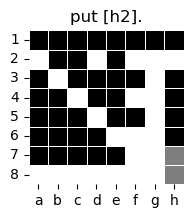

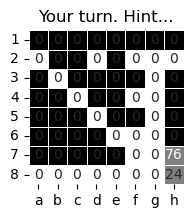

Your turn :  h8


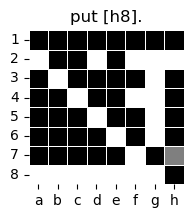

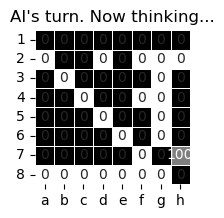

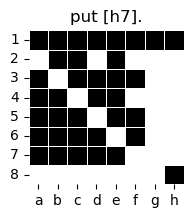

In [13]:
hint = True
board = Board()
show_board(board, "Your turn.")
while not board.is_game_over():
    legal_moves = list(board.legal_moves)
    if 64 in legal_moves: # パスの処理
        print(f"{'You' if board.turn else 'AI'} Passed.")
        move = 64
    elif not board.turn: # AIの番
        with torch.no_grad():
            p = model(torch.from_numpy(board_to_array(board)).unsqueeze(0).to(device)).cpu()
        p_legal = p[0][legal_moves]
        move = legal_moves[p_legal.argmax().item()]
        prob = p.softmax(dim=1).numpy().reshape(8,8) *100
        show_board(board,"AI's turn. Now thinking...",prob)
    else:  # ユーザーの番
        if hint:
            with torch.no_grad():
                p = model(torch.from_numpy(board_to_array(board)).unsqueeze(0).to(device)).cpu()
            prob = p.softmax(dim=1).numpy().reshape(8,8) *100
            show_board(board,"Your turn. Hint...",prob)
            
        move = receive_input(legal_moves)
        if move == '0': break
    board.move(move)
    show_board(board,f'put [{move_to_str(move)}].')

白番：You

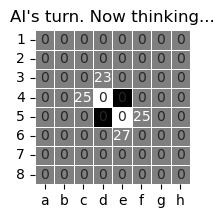

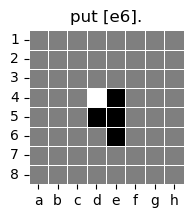

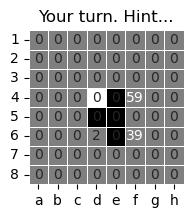

Your turn :  f4


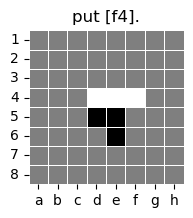

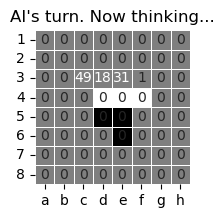

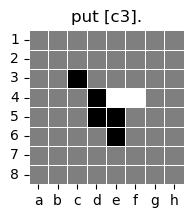

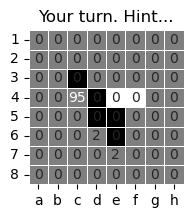

Your turn :  c4


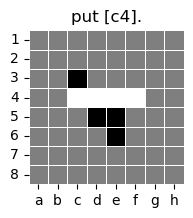

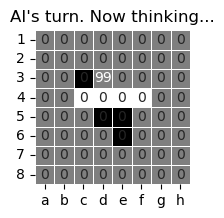

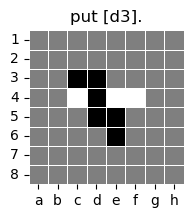

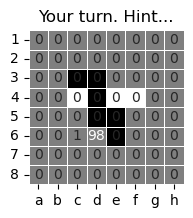

Your turn :  c2


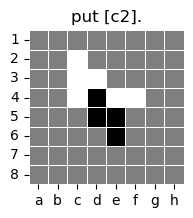

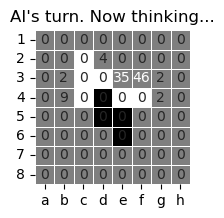

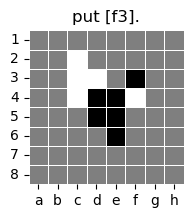

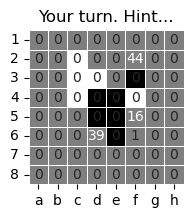

Your turn :  d6


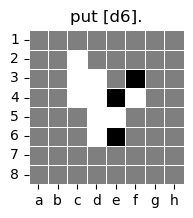

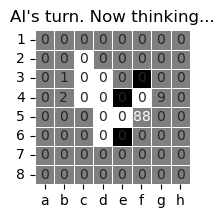

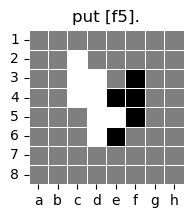

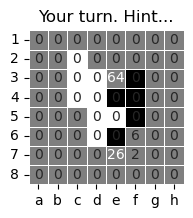

Your turn :  e3


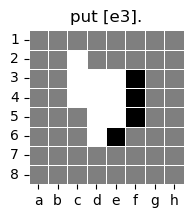

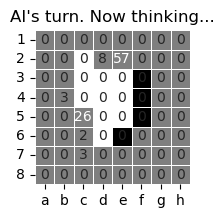

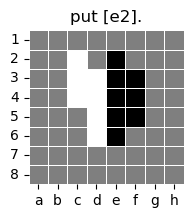

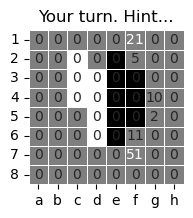

Your turn :  f1


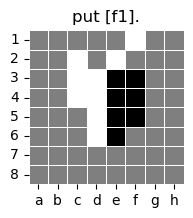

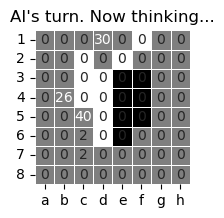

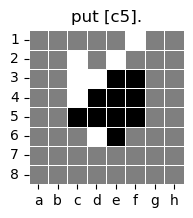

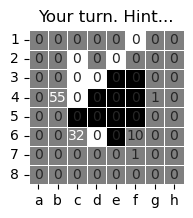

Your turn :  c6


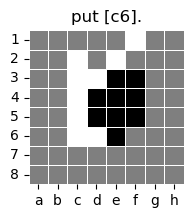

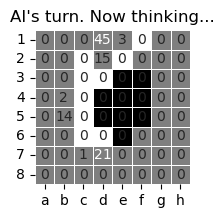

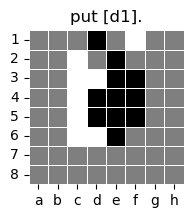

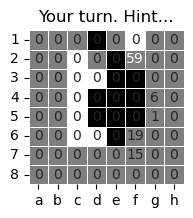

Your turn :  f2


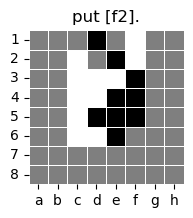

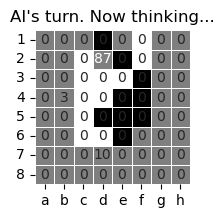

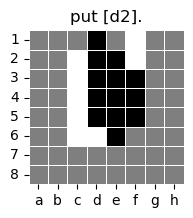

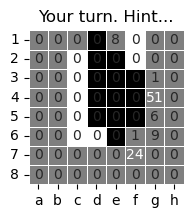

Your turn :  g4


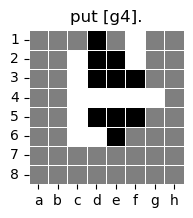

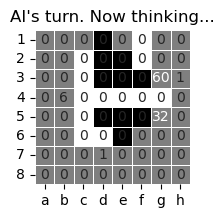

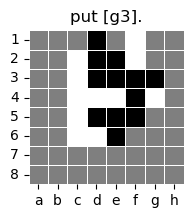

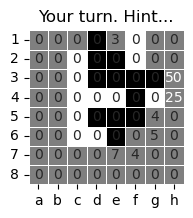

Your turn :  h3


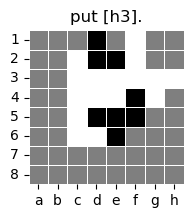

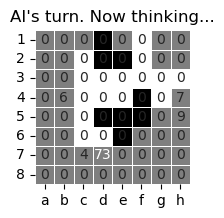

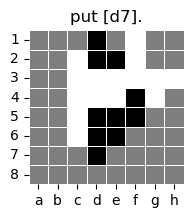

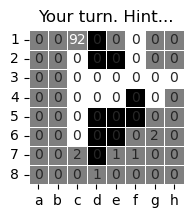

Your turn :  c1


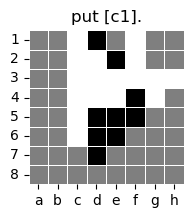

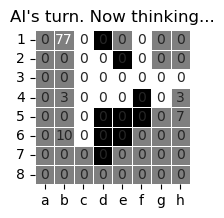

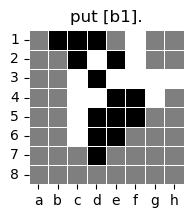

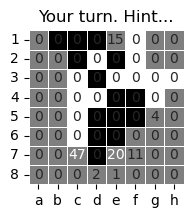

Your turn :  g5


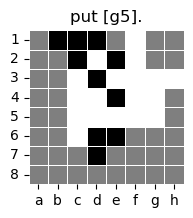

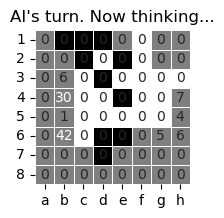

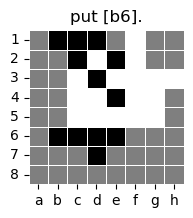

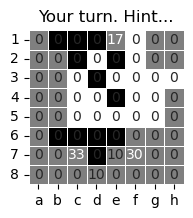

Your turn :  e1


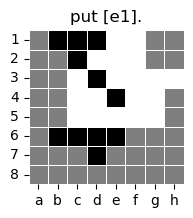

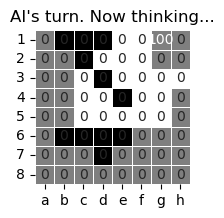

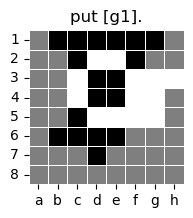

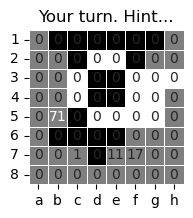

Your turn :  b5


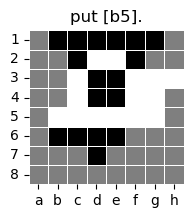

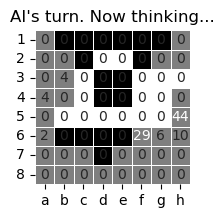

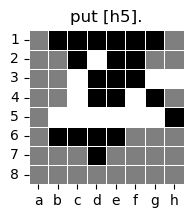

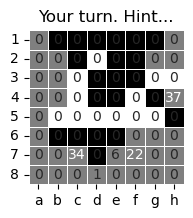

Your turn :  h4


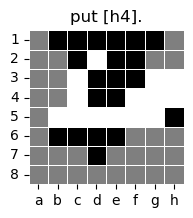

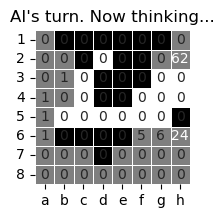

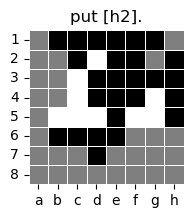

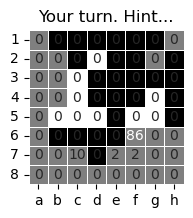

Your turn :  f6


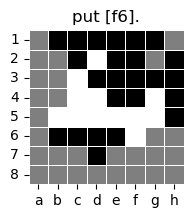

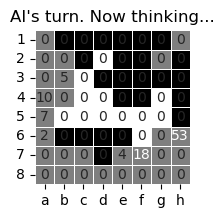

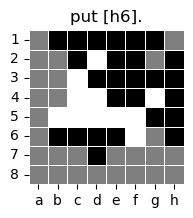

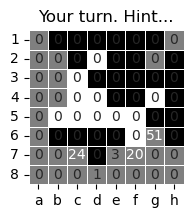

Your turn :  g6


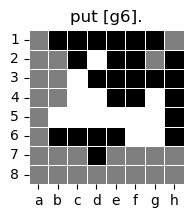

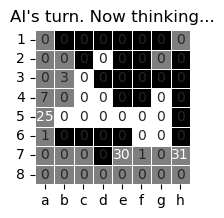

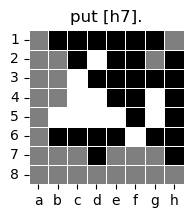

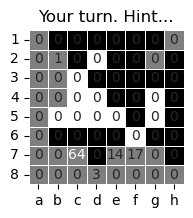

Your turn :  c7


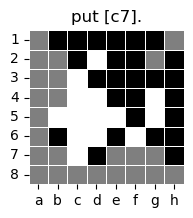

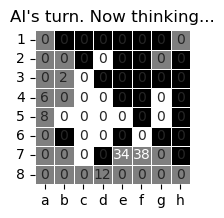

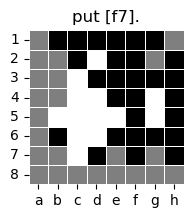

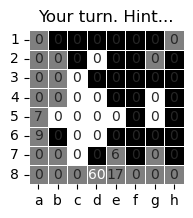

Your turn :  d8


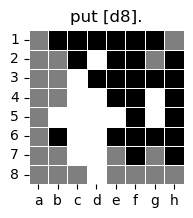

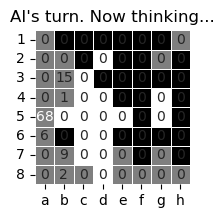

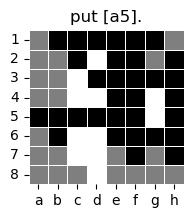

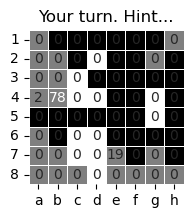

Your turn :  b4


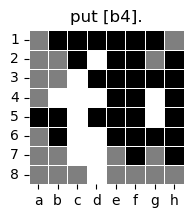

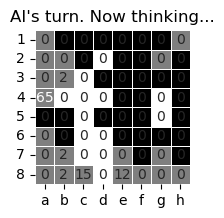

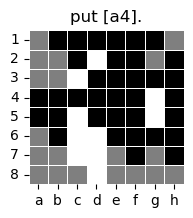

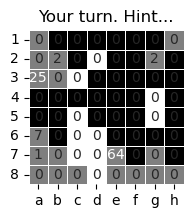

Your turn :  a3


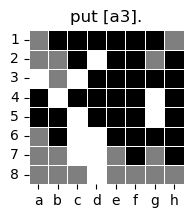

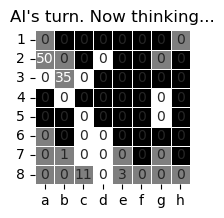

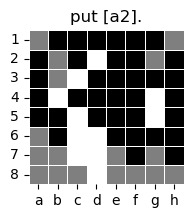

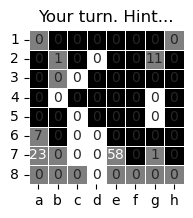

Your turn :  e7


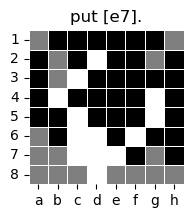

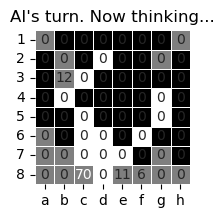

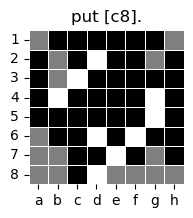

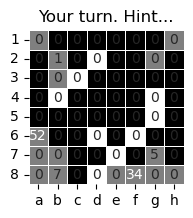

Your turn :  f8


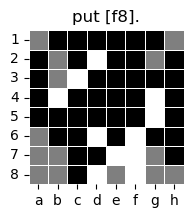

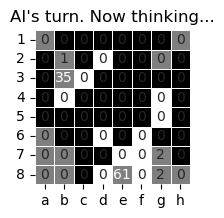

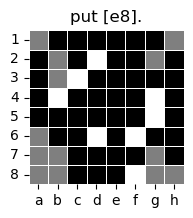

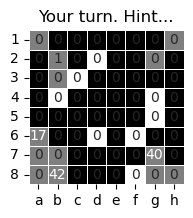

Your turn :  g7


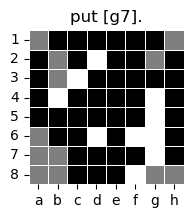

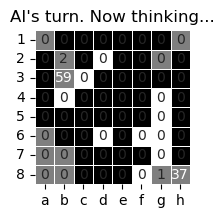

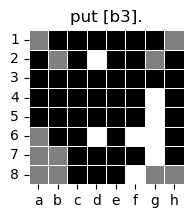

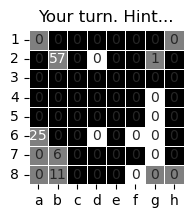

Your turn :  b2


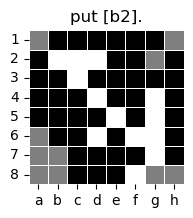

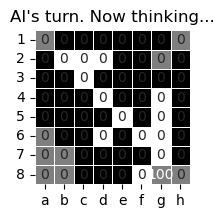

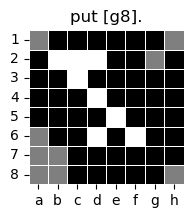

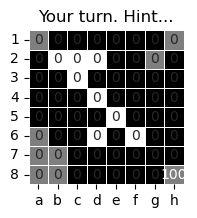

Your turn :  h8


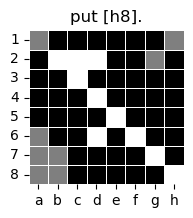

AI Passed.


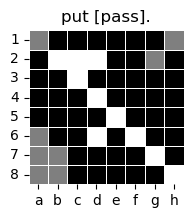

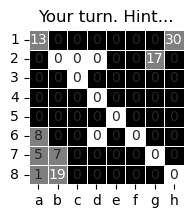

Your turn :  h1


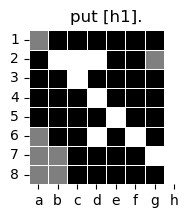

AI Passed.


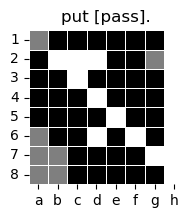

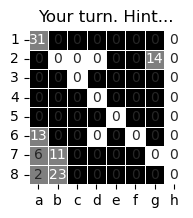

Your turn :  a1


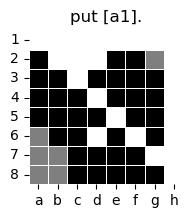

AI Passed.


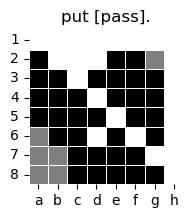

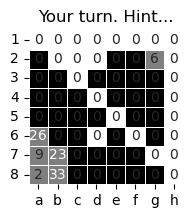

Your turn :  a6


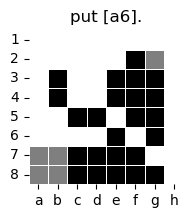

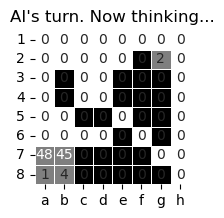

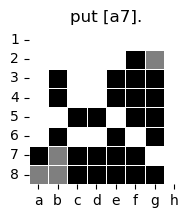

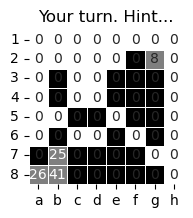

Your turn :  g2


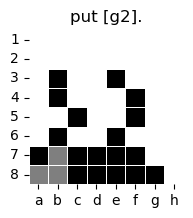

AI Passed.


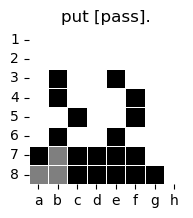

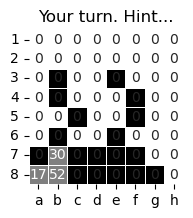

Your turn :  a8


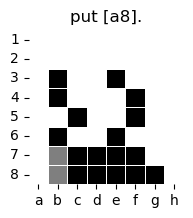

AI Passed.


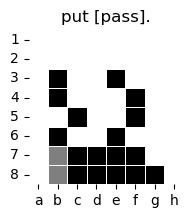

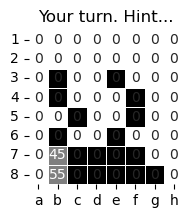

Your turn :  b8


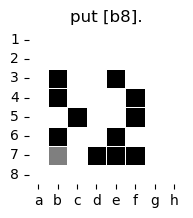

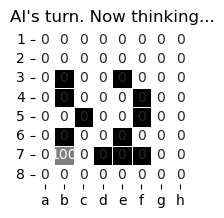

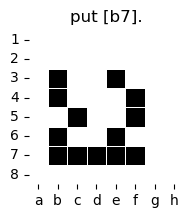

In [12]:
hint = True
board = Board()
while not board.is_game_over():
    legal_moves = list(board.legal_moves)
    if 64 in legal_moves: # パスの処理
        print(f"{'You' if not board.turn else 'AI'} Passed.")
        move = 64
    elif board.turn: # AIの番
        with torch.no_grad():
            p = model(torch.from_numpy(board_to_array(board)).unsqueeze(0).to(device)).cpu()
        p_legal = p[0][legal_moves]
        move = legal_moves[p_legal.argmax().item()]
        prob = p.softmax(dim=1).numpy().reshape(8,8) *100
        show_board(board,"AI's turn. Now thinking...",prob)
    else:  # ユーザーの番
        if hint:
            with torch.no_grad():
                p = model(torch.from_numpy(board_to_array(board)).unsqueeze(0).to(device)).cpu()
            prob = p.softmax(dim=1).numpy().reshape(8,8) *100
            show_board(board,"Your turn. Hint...",prob)
        move = receive_input(legal_moves)
        if move == '0': break
    board.move(move)
    show_board(board,f'put [{move_to_str(move)}].')

In [ ]:
# アンサンブルバージョン
board = Board()
while not board.is_game_over():
    legal_moves = list(board.legal_moves)
    if 64 in legal_moves: # パスの処理
        print(f"{'You' if not board.turn else 'AI'} Passed.")
        move = 64
    elif board.turn: # AIの番
        # 8パターンの盤面を生成
        board_array = board_to_array(board)
        boards = [board_array, np.flip(board_array,axis=2).copy()]
        for k in range(1,4):
            board_array_rot = np.rot90(board_array, k=k, axes=(1,2)).copy()
            boards.append(board_array_rot)
            boards.append(np.flip(board_array_rot, axis=2).copy())
        # 各パターンに対する予測
        probs = model(torch.from_numpy(np.array(boards)).to(device)).softmax(1).cpu().detach().numpy()
        probs_org = [probs[0], np.fliplr(probs[1].reshape(8,8)).flatten(),
                     np.rot90(probs[2].reshape(8,8), k=-1).copy().flatten(), np.rot90(np.fliplr(probs[3].reshape(8,8)), k=-1).copy().flatten(),
                     np.rot90(probs[4].reshape(8,8), k=-2).copy().flatten(), np.rot90(np.fliplr(probs[5].reshape(8,8)), k=-2).copy().flatten(),
                     np.rot90(probs[6].reshape(8,8), k=-3).copy().flatten(), np.rot90(np.fliplr(probs[7].reshape(8,8)), k=-3).copy().flatten()]
        probs_org = np.array(probs_org)
        # 平均を算出
        p = probs_org.mean(axis=0)
        p_legal = p[legal_moves]
        move = legal_moves[p_legal.argmax()]
        show_board(board,"AI's turn. Now thinking...", p.reshape(8,8) *100)
    else:  # ユーザーの番
        move = receive_input(legal_moves)
        if move == '0': break
    board.move(move)
    show_board(board,f'put [{move_to_str(move)}].')